In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import cv2

def create_attention_grid(
    model,             # a single VisionTransformer instance
    dataset,           # your CropDataset
    device,            # torch.device
    num_samples=10,    # how many images to plot
    rows=2, cols=5     # layout of the grid
):
    model.eval()
    fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*4))
    axes = axes.flatten()

    total = len(dataset)
    # pick evenly spaced samples (or replace with random.choice)
    indices = np.linspace(0, total-1, num_samples, dtype=int)

    for ax, idx in zip(axes, indices):
        # ─── 1) grab your multi-view tensor and label ───
        img_tensor, leaf_count, age = dataset[idx]
        # for display, take just the first RGB triplet:
        rgb = img_tensor[:3]                        # [3×H×W] → [3,H,W]

        # ─── 2) forward to get attention ───
        x = img_tensor.unsqueeze(0).to(device)      # [1, C, H, W]
        with torch.no_grad():
            _, attn_weights = model(x)  # attn_weights is List[layer][image] → Tensor[1, P, P]

        # ─── 3) pull out layer-wise maps for image 0 and stack ───
        #    each layer_weights is a list over self.num_images; we take [0]
        per_layer = [layer_weights[0] for layer_weights in attn_weights]
        # per_layer: list of Tensors, each [1, num_patches, num_patches]
        stack = torch.stack(per_layer, dim=0)       # [num_layers, 1, P, P]
        avg_layers = stack.mean(dim=0).squeeze(0)   # [P, P]

        # ─── 4) collapse source-token axis to get one value per patch ───
        #    here we take mean over rows → how much each patch is “attended to”
        patch_attn = avg_layers.mean(dim=0).cpu().numpy()  # [P]

        # ─── 5) reshape → (sqrt(P)×sqrt(P)) ───
        P = patch_attn.size
        side = int(np.sqrt(P))
        patch_attn = patch_attn[:side*side].reshape(side, side)

        # ─── 6) normalize & up-sample to H×W ───
        patch_attn = (patch_attn - patch_attn.min()) / (patch_attn.max() - patch_attn.min() + 1e-8)
        H, W = rgb.shape[1], rgb.shape[2]
        heatmap = cv2.resize(patch_attn, (W, H), interpolation=cv2.INTER_LINEAR)

        # ─── 7) plot overlay ───
        rgb_np = rgb.permute(1, 2, 0).cpu().numpy()
        ax.imshow(rgb_np)
        ax.imshow(heatmap, cmap='jet', alpha=0.5)
        ax.set_title(f"idx {idx}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()


cuda:1
multiple_selections: [[0, 90, 180, 270], [15, 105, 195, 285], [30, 120, 210, 300], [45, 135, 225, 315], [60, 150, 240, 330], [75, 165, 255, 345]]
day directory not found: /kaggle/input/mustard-dataset/mustard/content/drive/MyDrive/ACM grand challenge/Crops data/For_age_prediction/mustard/p1/d12
day directory not found: /kaggle/input/mustard-dataset/mustard/content/drive/MyDrive/ACM grand challenge/Crops data/For_age_prediction/mustard/p2/d12
day directory not found: /kaggle/input/mustard-dataset/mustard/content/drive/MyDrive/ACM grand challenge/Crops data/For_age_prediction/mustard/p2/d17
day directory not found: /kaggle/input/mustard-dataset/mustard/content/drive/MyDrive/ACM grand challenge/Crops data/For_age_prediction/mustard/p2/d19
Total samples loaded: 2100
1680 420


Epoch 1/10: 100%|██████████| 210/210 [17:55<00:00,  5.12s/it, Leaf RMSE=10.1, Age RMSE=12.5]

Epoch 1/10:   0%|          | 0/53 [21:50<?, ?it/s, Val Leaf RMSE=4.11, Val Age RMSE=5.08]

Epoch 1/10 - Train MAE Leaf: 7.9968, Train MAE Age: 10.1617, R² Leaf: -0.4513, R² Age: -0.3386
Validation - MAE Leaf: 6.7080, MAE Age: 8.7486, R² Leaf: 0.0781, R² Age: 0.1755


Epoch 2/10:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 2/10: 100%|██████████| 210/210 [13:41<00:00,  3.91s/it, Leaf RMSE=7.96, Age RMSE=8.54]


Epoch 2/10:   0%|          | 0/53 [13:44<?, ?it/s, Val Leaf RMSE=0.691, Val Age RMSE=0.455]

Epoch 2/10:   0%|          | 0/53 [13:48<?, ?it/s, Val Leaf RMSE=0.962, Val Age RMSE=0.894]

Epoch 2/10:   0%|          | 0/53 [13:52<?, ?it/s, Val Leaf RMSE=1.1, Val Age RMSE=1.2]    

Epoch 2/10:   0%|          | 0/53 [13:56<?, ?it/s, Val Leaf RMSE=1.21, Val Age RMSE=1.41]

Epoch 2/10:   0%|          | 0/53 [13:59<?, ?it/s, Val Leaf RMSE=1.35, Val Age RMSE=1.6] 

Epoch 2/10:   0%|          | 0/53 [14:03<?, ?it/s, Val Leaf RMSE=1.38, Val Age RMSE=1.76]

Epoch 2/10:   0%|          | 0/53 [14:07<?, ?it/s, Val Leaf RMSE=1.43, Val Age RMSE=1.83]

Epoch 2/10:   0%|          | 0/53 [14:11<?, ?it/s, Val Leaf RMSE=1.54, Val Age RMSE=1.88]

Epoch 2/10:   0%|          | 0/53 [14:15<?, ?it/s, Val Leaf RMSE=1.61, Val Age RMSE=1.91]

Epoch 2/10:   0%|          

Epoch 2/10 - Train MAE Leaf: 6.3729, Train MAE Age: 6.8221, R² Leaf: 0.0921, R² Age: 0.3798
Validation - MAE Leaf: 6.3067, MAE Age: 8.4242, R² Leaf: 0.1439, R² Age: 0.1530


Epoch 3/10: 100%|██████████| 210/210 [13:41<00:00,  3.91s/it, Leaf RMSE=7.66, Age RMSE=7.76]

Epoch 3/10:   0%|          | 0/53 [16:58<?, ?it/s, Val Leaf RMSE=4.08, Val Age RMSE=4.65]

Epoch 3/10 - Train MAE Leaf: 6.1212, Train MAE Age: 6.0171, R² Leaf: 0.1604, R² Age: 0.4881
Validation - MAE Leaf: 6.4096, MAE Age: 7.2545, R² Leaf: 0.0986, R² Age: 0.3071


Epoch 4/10:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 4/10: 100%|██████████| 210/210 [13:37<00:00,  3.89s/it, Leaf RMSE=7.38, Age RMSE=7.78]


Epoch 4/10:   0%|          | 0/53 [13:41<?, ?it/s, Val Leaf RMSE=0.754, Val Age RMSE=0.382]

Epoch 4/10:   0%|          | 0/53 [13:44<?, ?it/s, Val Leaf RMSE=1.04, Val Age RMSE=0.765] 

Epoch 4/10:   0%|          | 0/53 [13:48<?, ?it/s, Val Leaf RMSE=1.19, Val Age RMSE=1.05] 

Epoch 4/10:   0%|          | 0/53 [13:52<?, ?it/s, Val Leaf RMSE=1.29, Val Age RMSE=1.35]

Epoch 4/10:   0%|          | 0/53 [13:55<?, ?it/s, Val Leaf RMSE=1.39, Val Age RMSE=1.54]

Epoch 4/10:   0%|          | 0/53 [13:59<?, ?it/s, Val Leaf RMSE=1.43, Val Age RMSE=1.7] 

Epoch 4/10:   0%|          | 0/53 [14:03<?, ?it/s, Val Leaf RMSE=1.49, Val Age RMSE=1.73]

Epoch 4/10:   0%|          | 0/53 [14:07<?, ?it/s, Val Leaf RMSE=1.64, Val Age RMSE=1.79]

Epoch 4/10:   0%|          | 0/53 [14:10<?, ?it/s, Val Leaf RMSE=1.72, Val Age RMSE=1.87]

Epoch 4/10:   0%|          |

Epoch 4/10 - Train MAE Leaf: 5.8805, Train MAE Age: 6.0165, R² Leaf: 0.2204, R² Age: 0.4849
Validation - MAE Leaf: 6.2885, MAE Age: 8.4724, R² Leaf: 0.1295, R² Age: 0.0482


Epoch 5/10: 100%|██████████| 210/210 [13:43<00:00,  3.92s/it, Leaf RMSE=7.09, Age RMSE=7.11]

Epoch 5/10:   0%|          | 0/53 [16:59<?, ?it/s, Val Leaf RMSE=4.17, Val Age RMSE=5.78]

Epoch 5/10 - Train MAE Leaf: 5.5709, Train MAE Age: 5.5111, R² Leaf: 0.2790, R² Age: 0.5703
Validation - MAE Leaf: 6.5964, MAE Age: 9.1280, R² Leaf: 0.0579, R² Age: -0.0672


Epoch 6/10:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 6/10: 100%|██████████| 210/210 [13:36<00:00,  3.89s/it, Leaf RMSE=6.64, Age RMSE=7.14]


Epoch 6/10:   0%|          | 0/53 [13:39<?, ?it/s, Val Leaf RMSE=0.767, Val Age RMSE=0.414]

Epoch 6/10:   0%|          | 0/53 [13:43<?, ?it/s, Val Leaf RMSE=1.07, Val Age RMSE=0.739] 

Epoch 6/10:   0%|          | 0/53 [13:47<?, ?it/s, Val Leaf RMSE=1.16, Val Age RMSE=1.01] 

Epoch 6/10:   0%|          | 0/53 [13:51<?, ?it/s, Val Leaf RMSE=1.23, Val Age RMSE=1.42]

Epoch 6/10:   0%|          | 0/53 [13:54<?, ?it/s, Val Leaf RMSE=1.3, Val Age RMSE=1.62] 

Epoch 6/10:   0%|          | 0/53 [13:58<?, ?it/s, Val Leaf RMSE=1.34, Val Age RMSE=1.8]

Epoch 6/10:   0%|          | 0/53 [14:02<?, ?it/s, Val Leaf RMSE=1.37, Val Age RMSE=1.83]

Epoch 6/10:   0%|          | 0/53 [14:06<?, ?it/s, Val Leaf RMSE=1.5, Val Age RMSE=1.91] 

Epoch 6/10:   0%|          | 0/53 [14:09<?, ?it/s, Val Leaf RMSE=1.55, Val Age RMSE=1.99]

Epoch 6/10:   0%|          | 

Epoch 6/10 - Train MAE Leaf: 5.2517, Train MAE Age: 5.4701, R² Leaf: 0.3689, R² Age: 0.5663
Validation - MAE Leaf: 4.9886, MAE Age: 9.2022, R² Leaf: 0.3884, R² Age: -0.0730


Epoch 7/10: 100%|██████████| 210/210 [13:34<00:00,  3.88s/it, Leaf RMSE=6.12, Age RMSE=6.78]

Epoch 7/10:   0%|          | 0/53 [16:51<?, ?it/s, Val Leaf RMSE=3.27, Val Age RMSE=4.28]

Epoch 7/10 - Train MAE Leaf: 4.6825, Train MAE Age: 5.1818, R² Leaf: 0.4633, R² Age: 0.6088
Validation - MAE Leaf: 4.6099, MAE Age: 6.8572, R² Leaf: 0.4291, R² Age: 0.4147


Epoch 8/10:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 8/10: 100%|██████████| 210/210 [13:38<00:00,  3.90s/it, Leaf RMSE=5.44, Age RMSE=6.62]


Epoch 8/10:   0%|          | 0/53 [13:42<?, ?it/s, Val Leaf RMSE=0.733, Val Age RMSE=0.296]

Epoch 8/10:   0%|          | 0/53 [13:45<?, ?it/s, Val Leaf RMSE=1.03, Val Age RMSE=0.451] 

Epoch 8/10:   0%|          | 0/53 [13:49<?, ?it/s, Val Leaf RMSE=1.07, Val Age RMSE=0.745]

Epoch 8/10:   0%|          | 0/53 [13:53<?, ?it/s, Val Leaf RMSE=1.16, Val Age RMSE=1.11] 

Epoch 8/10:   0%|          | 0/53 [13:57<?, ?it/s, Val Leaf RMSE=1.19, Val Age RMSE=1.3] 

Epoch 8/10:   0%|          | 0/53 [14:00<?, ?it/s, Val Leaf RMSE=1.2, Val Age RMSE=1.46]

Epoch 8/10:   0%|          | 0/53 [14:04<?, ?it/s, Val Leaf RMSE=1.26, Val Age RMSE=1.49]

Epoch 8/10:   0%|          | 0/53 [14:08<?, ?it/s, Val Leaf RMSE=1.41, Val Age RMSE=1.54]

Epoch 8/10:   0%|          | 0/53 [14:12<?, ?it/s, Val Leaf RMSE=1.5, Val Age RMSE=1.6]  

Epoch 8/10:   0%|          |

Epoch 8/10 - Train MAE Leaf: 4.0599, Train MAE Age: 4.9740, R² Leaf: 0.5759, R² Age: 0.6279
Validation - MAE Leaf: 4.9294, MAE Age: 7.5352, R² Leaf: 0.3788, R² Age: 0.2435


Epoch 9/10: 100%|██████████| 210/210 [13:38<00:00,  3.90s/it, Leaf RMSE=5.02, Age RMSE=6.35]

Epoch 9/10:   0%|          | 0/53 [16:55<?, ?it/s, Val Leaf RMSE=2.82, Val Age RMSE=6.7] 

Epoch 9/10 - Train MAE Leaf: 3.7327, Train MAE Age: 4.7816, R² Leaf: 0.6389, R² Age: 0.6572
Validation - MAE Leaf: 3.7676, MAE Age: 11.5008, R² Leaf: 0.5698, R² Age: -0.4315


Epoch 10/10:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 10/10: 100%|██████████| 210/210 [13:36<00:00,  3.89s/it, Leaf RMSE=4.38, Age RMSE=6.36]


Epoch 10/10:   0%|          | 0/53 [13:40<?, ?it/s, Val Leaf RMSE=0.518, Val Age RMSE=0.371]

Epoch 10/10:   0%|          | 0/53 [13:43<?, ?it/s, Val Leaf RMSE=0.719, Val Age RMSE=0.602]

Epoch 10/10:   0%|          | 0/53 [13:47<?, ?it/s, Val Leaf RMSE=0.792, Val Age RMSE=0.884]

Epoch 10/10:   0%|          | 0/53 [13:51<?, ?it/s, Val Leaf RMSE=0.857, Val Age RMSE=1.18] 

Epoch 10/10:   0%|          | 0/53 [13:55<?, ?it/s, Val Leaf RMSE=0.892, Val Age RMSE=1.35]

Epoch 10/10:   0%|          | 0/53 [13:58<?, ?it/s, Val Leaf RMSE=0.969, Val Age RMSE=1.52]

Epoch 10/10:   0%|          | 0/53 [14:02<?, ?it/s, Val Leaf RMSE=1.03, Val Age RMSE=1.55] 

Epoch 10/10:   0%|          | 0/53 [14:06<?, ?it/s, Val Leaf RMSE=1.06, Val Age RMSE=1.61]

Epoch 10/10:   0%|          | 0/53 [14:10<?, ?it/s, Val Leaf RMSE=1.08, Val Age RMSE=1.65]

Epoch 10/10

Epoch 10/10 - Train MAE Leaf: 3.2847, Train MAE Age: 4.8465, R² Leaf: 0.7253, R² Age: 0.6557
Validation - MAE Leaf: 3.9910, MAE Age: 7.4320, R² Leaf: 0.6193, R² Age: 0.3162
Models saved successfully!
Train Losses Leaf: [145.86844019126934, 115.37561137077715, 110.95220866091503, 106.91116339112173, 102.81455306580224, 96.1953319090092, 88.70676481712646, 78.85736450873493, 72.76245835720353, 63.45986967821502]
Validation Losses Leaf: [59.61259951288225, 57.53361815510631, 59.19365722146314, 58.160260963589074, 60.442303960702915, 48.87478368374695, 47.33427662760188, 49.138215764940625, 40.846910957073696, 38.10802733543651]
Train Losses Age: [181.8263404747476, 123.76397431973693, 112.4375828885276, 112.79598488425424, 103.01329602837865, 103.49675883640788, 98.29058455394016, 95.86259096653406, 92.01638113868407, 92.2159456727012]
Validation Losses Age: [73.64893305692611, 74.59820954984102, 67.43834406454422, 79.10846954556865, 83.79177069851187, 84.04098216055293, 62.02789189163570

Epoch 10/10:   0%|          | 0/53 [16:55<?, ?it/s, Val Leaf RMSE=2.63, Val Age RMSE=4.63]

1
Graphs saved as PNG and PDF!


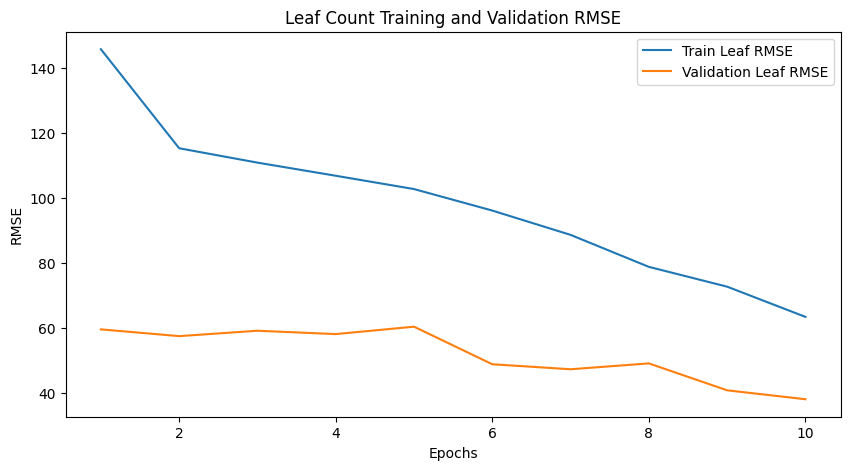

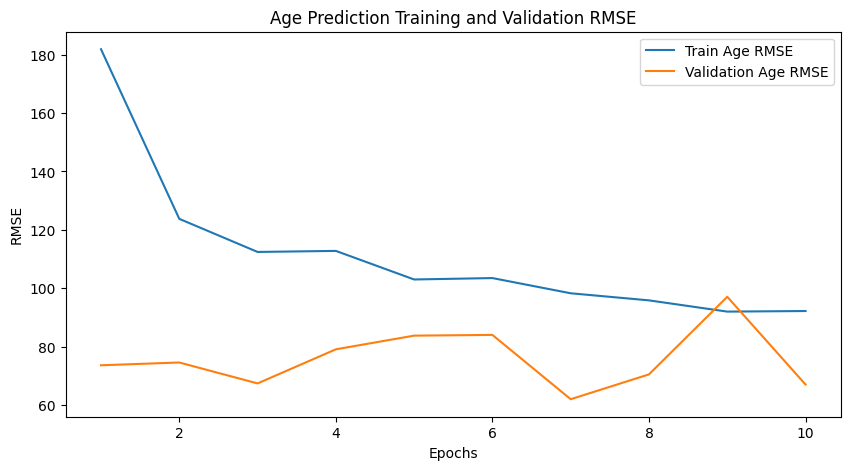

In [2]:
# main.py


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import os
from PIL import Image
import random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import r2_score, mean_absolute_error

# Define the device (GPU or CPU)
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)
################################# Input here ###################################
root_path='/kaggle/input/mustard-dataset/mustard/content/drive/MyDrive/ACM grand challenge/Crops data/For_age_prediction'
crop='mustard'
csv_file='/kaggle/input/mustard-dataset/Ground Truth/Ground Truth/mustard_train.csv'
n_images=4
epochs=10
plant_input=2
days_input=37
batch_size = 8
seed=42
height, width = 224, 224
# Transformations for resizing and converting to tensor
transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
##############################################################################

# Set random seeds for reproducibility
def set_seed(seed=42):
    """
    Set random seeds for Python, NumPy, and PyTorch to ensure reproducibility.
    """
    random.seed(seed)  # Python random seed
    np.random.seed(seed)  # Numpy random seed
    torch.manual_seed(seed)  # PyTorch CPU seed
    torch.cuda.manual_seed(seed)  # PyTorch GPU seed (for CUDA)
    torch.cuda.manual_seed_all(seed)  # For multi-GPU setups

    # Ensure deterministic behavior in CUDA (if using GPU)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Initialize seed for reproducibility
set_seed(42)

num_images = n_images  # Number of images (24 RGB images)
input_channels = num_images*3  # 24 RGB images (3 channels each)
patch_size = 16  # Size of each patch
num_patches = (height // patch_size) * (width // patch_size)  # Number of patches (14 * 14 for 224x224 images)
projection_dim = 256  # Embedding dimension for each patch
num_heads = 8  # Number of attention heads
num_layers = 6  # Number of transformer layers
mlp_dim = 512  # Dimension of the MLP head
num_classes = 1  # Number of output classes (for day or leaf count prediction)
dropout_rate = 0.1  # Dropout rate


class CropDataset(Dataset):
    def __init__(self, root_dir, csv_file, images_per_level, crop, plants, days,
                 levels=['L1', 'L2', 'L3', 'L4', 'L5'], transform=None):
        """
        Args:
            root_dir (str): Directory with all the images.
            csv_file (str): Path to the CSV file containing ground truth (filename, leaf_count, age).
            images_per_level (int): Number of images to select per level (should be factors of 24).
            crop (str): Crop type (e.g., "mustard").
            plants (int): Number of plants (e.g., 4).
            days (int): Number of days (e.g., 59).
            levels (list): List of levels (e.g., ['L1', 'L2', 'L3', 'L4', 'L5']).
            transform (callable, optional): Transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.csv_file = csv_file
        self.images_per_level = images_per_level
        self.crop = crop
        self.plants_num = plants
        self.max_days = days
        self.levels = levels
        self.transform = transform
        self.image_data = self._load_metadata()
        self.image_paths = self._load_image_paths()

    def _load_metadata(self):
        """Load CSV file into a pandas DataFrame and map filenames to leaf counts and ages."""
        df = pd.read_csv(self.csv_file)
        df["filename"] = df["filename"].astype(str)  # Ensure filenames are strings
        return df.set_index("filename")  # Use filename as the index for quick lookup

    def _select_angles(self):
        """
        Select angles dynamically for a given level.
        """
        images_needed = self.images_per_level
        selected_angles = [i for i in range(0, 360, int(360 / images_needed))]

        initial_angles = [i for i in range(15, selected_angles[1], 15)]
        multiple_selections = [selected_angles]

        for initial_angle in initial_angles:
            selection = [initial_angle]
            while len(selection) < images_needed:
                next_angle = (selection[-1] + int(360 / images_needed)) % 360
                if next_angle not in selection:
                    selection.append(next_angle)
            multiple_selections.append(selection)
        print(f"multiple_selections: {multiple_selections}")
        return multiple_selections

    def _load_image_paths(self):
        """
        Load image paths for all levels and plants based on the selection of angles.
        """
        image_paths = []
        multiple_selections = self._select_angles()

        for plant in range(1, self.plants_num + 1):
            plant_path = os.path.join(self.root_dir, crop, f"p{plant}")
            if not os.path.isdir(plant_path):
                print(f"Plant directory not found: {plant_path}")
                continue
            for day in range(1, self.max_days + 1):
                day_path = os.path.join(self.root_dir, crop, f"p{plant}", f"d{day}")
                if not os.path.isdir(day_path):
                    print(f"day directory not found: {day_path}")
                    continue
                for selected_angles in multiple_selections:
                    for level in self.levels:
                        level_path = os.path.join(self.root_dir,self.crop, f"p{plant}", f"d{day}", level)
                        level_image_paths = [
                            os.path.join(level_path, f"{self.crop}_p{plant}_d{day}_{level}_{angle}.png")
                            for angle in selected_angles
                        ]
                        filename = os.path.join(self.crop,f"p{plant}", f"d{day}", level,f"{self.crop}_p{plant}_d{day}_{level}_{selected_angles[0]}.png")
                        leaf_count = self.image_data.loc[filename, "leaf_count"]
                        # print(level_image_paths)
                        image_paths.append((level_image_paths, leaf_count,day))  # Append day number along with image paths

        print(f"Total samples loaded: {len(image_paths)}")
        # print(f"individual sample size: {len(image_paths[0][0])}")
        return image_paths


    def __len__(self):
        return len(self.image_paths)


    def __getitem__(self, idx):
        """
        Get a batch of images from the dataset corresponding to the angles selected.
        """
        images = []
        leaf_count = self.image_paths[idx][1]
        age = self.image_paths[idx][2]
        # print(leaf_count,age)
        all_images= self.image_paths[idx][0]
        # print("length of all images:", len(all_images))
        for img_path in all_images:  # Get the image paths for this sample
            if os.path.isfile(img_path):
                  level_image = Image.open(img_path)
                  if self.transform:
                      level_image = self.transform(level_image)
                  images.append(level_image)
            else:
                    print(f"Path is not a valid file: {img_path}")

        images = torch.cat(images, dim=0)

        return images, torch.tensor(leaf_count, dtype=torch.float32), torch.tensor(age, dtype=torch.float32)  # Return both images and the corresponding day as ground truth

dataset = CropDataset(root_dir=root_path,
                      csv_file=csv_file,
                      images_per_level=n_images,
                      crop=crop,
                      plants=plant_input,
                      days=days_input,
                      transform=transform)
# Split the dataset into training and validation sets
train_size = int(0.8 * len(dataset))  # 80% for training
val_size = len(dataset) - train_size  # 20% for validation
print(train_size,val_size)
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# DataLoader for training and validation sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)



class VisionTransformer(nn.Module):
    def __init__(self, input_channels, patch_size, num_patches, projection_dim, num_heads, num_layers, mlp_dim, num_images, dropout_rate=0.1):
        super(VisionTransformer, self).__init__()

        self.num_images = num_images  # Total number of images (24 images in your case)
        self.patch_size = patch_size
        self.num_patches = num_patches
        self.projection_dim = projection_dim
        self.num_heads = num_heads
        self.num_layers = num_layers
        self.mlp_dim = mlp_dim

        # Separate patch embedding layers for each image (RGB)
        self.patch_embeds = nn.ModuleList([
            nn.Conv2d(input_channels // num_images, projection_dim, kernel_size=patch_size, stride=patch_size)
            for _ in range(num_images)
        ])

        # Positional Encoding (Learnable)
        self.positional_encoding = nn.Parameter(torch.randn(1, num_patches, projection_dim))

        # Transformer Encoder Layers (modified to return attention weights)
        self.attention_layers = nn.ModuleList([
            nn.TransformerEncoderLayer(
                d_model=projection_dim,
                nhead=num_heads,
                dim_feedforward=mlp_dim,
                dropout=dropout_rate,
                batch_first=True
            )
            for _ in range(num_layers)
        ])

        # MLP Head for classification/regression
        self.mlp_head = nn.Sequential(
            nn.Linear(projection_dim * num_images, mlp_dim),
            nn.ReLU(),
            nn.Linear(mlp_dim, 1)
        )

    def forward(self, x):
        batch_size = x.shape[0]

        # Step 1: Patch Embedding (Separate for each image)
        patch_embeddings = []
        for i in range(self.num_images):
            # Split the input channels into separate images (3 channels each for RGB)
            img_x = x[:, i*3:(i+1)*3, :, :]  # Shape: (batch_size, 3, height, width)
            patch_embed = self.patch_embeds[i](img_x)  # Apply separate embedding
            patch_embed = patch_embed.flatten(2).transpose(1, 2)  # Shape: (batch_size, num_patches, projection_dim)
            patch_embeddings.append(patch_embed)

        # Step 2: Add Positional Encoding
        patch_embeddings = [pe + self.positional_encoding for pe in patch_embeddings]

        # Step 3: Transformer Encoder Layers (Self-attention + Feed Forward)
        attention_weights = []  # To store attention weights
        for layer in self.attention_layers:
            layer_attention_weights = []  # Store the attention weights for each layer
            for i in range(self.num_images):
                # Modified to return attention weights (self-attention)
                attn_output, attn_weights = layer.self_attn(patch_embeddings[i], patch_embeddings[i], patch_embeddings[i])
                patch_embeddings[i] = attn_output
                layer_attention_weights.append(attn_weights)
            attention_weights.append(layer_attention_weights)

        # Step 4: Concatenate the projections from each image (Shape: (batch_size, num_patches, projection_dim * num_images))
        x = torch.cat(patch_embeddings, dim=-1)  # Concatenate across the last dimension (projection_dim)

        # Step 5: Pooling (Take mean across all patches)
        x = x.mean(dim=1)  # Mean pooling over patches (Shape: (batch_size, projection_dim * num_images))

        # Step 6: MLP Head for classification/regression
        output = self.mlp_head(x)

        return output, attention_weights  # Return attention weights too

# Create two independent instances of the model

def create_model():
    return VisionTransformer(input_channels, patch_size, num_patches, projection_dim, num_heads, num_layers, mlp_dim, num_images, dropout_rate)

# Create two independent instances of the model
model = [create_model(), create_model()]

model[0].to(device)
model[1].to(device)
optimizer = [optim.Adam(model[0].parameters(), lr=0.0001), optim.Adam(model[1].parameters(), lr=0.0001)]
criterion = nn.MSELoss()

def train_and_validate(train_loader, val_loader, num_epochs=10):
    train_losses_leaf, train_losses_age, val_losses_leaf, val_losses_age = [], [], [], []
    train_mae_leaf, train_mae_age, val_mae_leaf, val_mae_age = [], [], [], []
    train_r2_leaf, train_r2_age, val_r2_leaf, val_r2_age = [], [], [], []

    for epoch in range(num_epochs):
        # Training Phase
        for i in range(2):
            model[i].train()

        total_loss = [0, 0]
        train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
        val_loader_tqdm = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
        all_preds, all_labels = [[], []], [[], []]
        
        for batch_idx, (images, leaf_labels, age_labels) in enumerate(train_loader_tqdm):
            images, leaf_labels, age_labels = images.to(device), leaf_labels.to(device), age_labels.to(device)
            
            for i in range(2):
                optimizer[i].zero_grad()
                preds, _ = model[i](images)
                loss = criterion(preds.squeeze(), leaf_labels if i == 0 else age_labels)
                loss.backward()
                optimizer[i].step()
                total_loss[i] += loss.item()
                
                all_preds[i].extend(preds.squeeze().cpu().detach().numpy())
                all_labels[i].extend((leaf_labels if i == 0 else age_labels).cpu().numpy())

            train_loader_tqdm.set_postfix({"Leaf RMSE": (total_loss[0]/(batch_idx+1))**0.5, "Age RMSE": (total_loss[1]/(batch_idx+1))**0.5})

        train_losses_leaf.append(total_loss[0]**0.5)
        train_losses_age.append(total_loss[1]**0.5)
        train_mae_leaf.append(mean_absolute_error(all_labels[0], all_preds[0]))
        train_mae_age.append(mean_absolute_error(all_labels[1], all_preds[1]))
        train_r2_leaf.append(r2_score(all_labels[0], all_preds[0]))
        train_r2_age.append(r2_score(all_labels[1], all_preds[1]))

        # Validation Phase
        for i in range(2):
            model[i].eval()

        total_val_loss = [0, 0]
        all_val_preds, all_val_labels = [[], []], [[], []]

        with torch.no_grad():
            for images, leaf_labels, age_labels in val_loader:
                images, leaf_labels, age_labels = images.to(device), leaf_labels.to(device), age_labels.to(device)
                
                for i in range(2):
                    preds, _ = model[i](images)
                    loss = criterion(preds.squeeze(), leaf_labels if i == 0 else age_labels)
                    total_val_loss[i] += loss.item()
                    
                    all_val_preds[i].extend(preds.squeeze().cpu().numpy())
                    all_val_labels[i].extend((leaf_labels if i == 0 else age_labels).cpu().numpy())
                val_loader_tqdm.set_postfix({"Val Leaf RMSE": (total_val_loss[0]/(batch_idx+1))**0.5, "Val Age RMSE": (total_val_loss[1]/(batch_idx+1))**0.5})

        val_losses_leaf.append(total_val_loss[0]**0.5)
        val_losses_age.append(total_val_loss[1]**0.5)
        val_mae_leaf.append(mean_absolute_error(all_val_labels[0], all_val_preds[0]))
        val_mae_age.append(mean_absolute_error(all_val_labels[1], all_val_preds[1]))
        val_r2_leaf.append(r2_score(all_val_labels[0], all_val_preds[0]))
        val_r2_age.append(r2_score(all_val_labels[1], all_val_preds[1]))

        print(f"Epoch {epoch+1}/{num_epochs} - Train MAE Leaf: {train_mae_leaf[-1]:.4f}, Train MAE Age: {train_mae_age[-1]:.4f}, R² Leaf: {train_r2_leaf[-1]:.4f}, R² Age: {train_r2_age[-1]:.4f}")
        print(f"Validation - MAE Leaf: {val_mae_leaf[-1]:.4f}, MAE Age: {val_mae_age[-1]:.4f}, R² Leaf: {val_r2_leaf[-1]:.4f}, R² Age: {val_r2_age[-1]:.4f}")
        torch.save(model[0].state_dict(), f"mustard_vit_leaf_count_{epoch+1}.pth")
        torch.save(model[1].state_dict(), f"mustard_vit_age_prediction_{epoch+1}.pth")

    torch.save(model[0].state_dict(), "mustard_vit_leaf_count.pth")
    torch.save(model[1].state_dict(), "mustard_vit_age_prediction.pth")
    print("Models saved successfully!")

    print("Train Losses Leaf:", train_losses_leaf)
    print("Validation Losses Leaf:", val_losses_leaf)
    print("Train Losses Age:", train_losses_age)
    print("Validation Losses Age:", val_losses_age)
    print(num_epochs)


    plt.figure(figsize=(10,5))
    plt.plot(range(1, num_epochs+1), train_losses_leaf, label='Train Leaf RMSE')
    plt.plot(range(1, num_epochs+1), val_losses_leaf, label='Validation Leaf RMSE')
    plt.xlabel("Epochs")
    plt.ylabel("RMSE")
    plt.legend()
    plt.title("Leaf Count Training and Validation RMSE")
    plt.savefig("leaf_training_validation_rmse.png")
    plt.savefig("leaf_training_validation_rmse.pdf")
    print('1')
    plt.figure(figsize=(10,5))
    plt.plot(range(1, num_epochs+1), train_losses_age, label='Train Age RMSE')
    plt.plot(range(1, num_epochs+1), val_losses_age, label='Validation Age RMSE')
    plt.xlabel("Epochs")
    plt.ylabel("RMSE")
    plt.legend()
    plt.title("Age Prediction Training and Validation RMSE")
    plt.savefig("age_training_validation_rmse.png")
    plt.savefig("age_training_validation_rmse.pdf")
    print("Graphs saved as PNG and PDF!")

train_and_validate(train_loader, val_loader, num_epochs=epochs)


In [5]:
# test_py.py
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import os
from PIL import Image
import random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import r2_score, mean_absolute_error

# Define the device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

################################# Input here ###################################
root_path='/kaggle/input/mustard-dataset/mustard/content/drive/MyDrive/ACM grand challenge/Crops data/For_age_prediction'
crop='mustard'
csv_file='/kaggle/input/mustard-dataset/Ground Truth/Ground Truth/mustard_train.csv'
n_images=4
plant_input=3
days_input=37
batch_size = 8
seed=42
height, width = 224, 224
# Transformations for resizing and converting to tensor
transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
##############################################################################

class CropDataset(Dataset):
    def __init__(self, root_dir, csv_file, images_per_level, crop, plants, days,
                 levels=['L1', 'L2', 'L3', 'L4', 'L5'], transform=None):
        """
        Args:
            root_dir (str): Directory with all the images.
            csv_file (str): Path to the CSV file containing ground truth (filename, leaf_count, age).
            images_per_level (int): Number of images to select per level (should be factors of 24).
            crop (str): Crop type (e.g., "mustard").
            plants (int): Number of plants (e.g., 4).
            days (int): Number of days (e.g., 59).
            levels (list): List of levels (e.g., ['L1', 'L2', 'L3', 'L4', 'L5']).
            transform (callable, optional): Transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.csv_file = csv_file
        self.images_per_level = images_per_level
        self.crop = crop
        self.plants_num = plants
        self.max_days = days
        self.levels = levels
        self.transform = transform
        self.image_data = self._load_metadata()
        self.image_paths = self._load_image_paths()

    def _load_metadata(self):
        """Load CSV file into a pandas DataFrame and map filenames to leaf counts and ages."""
        df = pd.read_csv(self.csv_file)
        df["filename"] = df["filename"].astype(str)  # Ensure filenames are strings
        return df.set_index("filename")  # Use filename as the index for quick lookup

    def _select_angles(self):
        """
        Select angles dynamically for a given level.
        """
        images_needed = self.images_per_level
        selected_angles = [i for i in range(0, 360, int(360 / images_needed))]

        initial_angles = [i for i in range(15, selected_angles[1], 15)]
        multiple_selections = [selected_angles]

        for initial_angle in initial_angles:
            selection = [initial_angle]
            while len(selection) < images_needed:
                next_angle = (selection[-1] + int(360 / images_needed)) % 360
                if next_angle not in selection:
                    selection.append(next_angle)
            multiple_selections.append(selection)
        print(multiple_selections)
        return multiple_selections

    def _load_image_paths(self):
        """
        Load image paths for all levels and plants based on the selection of angles.
        """
        image_paths = []
        multiple_selections = self._select_angles()

        for plant in range(3, self.plants_num + 1):
            plant_path = os.path.join(self.root_dir, crop, f"p{plant}")
            if not os.path.isdir(plant_path):
                print(f"Plant directory not found: {plant_path}")
                continue
            for day in range(1, self.max_days + 1):
                day_path = os.path.join(self.root_dir, crop, f"p{plant}", f"d{day}")
                if not os.path.isdir(day_path):
                    continue
                for selected_angles in multiple_selections:
                    for level in self.levels:
                        level_path = os.path.join(self.root_dir,self.crop, f"p{plant}", f"d{day}", level)
                        level_image_paths = [
                            os.path.join(level_path, f"{self.crop}_p{plant}_d{day}_{level}_{angle}.png")
                            for angle in selected_angles
                        ]
                        filename = os.path.join(self.crop,f"p{plant}", f"d{day}", level,f"{self.crop}_p{plant}_d{day}_{level}_{selected_angles[0]}.png")
                        print(filename)
                        leaf_count = self.image_data.loc[filename, "leaf_count"]
                        # print(level_image_paths)
                        image_paths.append((level_image_paths, leaf_count,day))  # Append day number along with image paths

        print(f"Total samples loaded: {len(image_paths)}")
        # print(f"individual sample size: {len(image_paths[0][0])}")
        return image_paths


    def __len__(self):
        return len(self.image_paths)


    def __getitem__(self, idx):
        """
        Get a batch of images from the dataset corresponding to the angles selected.
        """
        images = []
        leaf_count = self.image_paths[idx][1]
        age = self.image_paths[idx][2]
        # print(leaf_count,age)
        all_images= self.image_paths[idx][0]
        # print("length of all images:", len(all_images))
        for img_path in all_images:  # Get the image paths for this sample
            if os.path.isfile(img_path):
                  level_image = Image.open(img_path)
                  if self.transform:
                      level_image = self.transform(level_image)
                  images.append(level_image)
            else:
                    print(f"Path is not a valid file: {img_path}")

        images = torch.cat(images, dim=0)

        return images, torch.tensor(leaf_count, dtype=torch.float32), torch.tensor(age, dtype=torch.float32)  # Return both images and the corresponding day as ground truth

test_dataset = CropDataset(root_dir=root_path,
                      csv_file=csv_file,
                      images_per_level=n_images,
                      crop=crop,
                      plants=plant_input,
                      days=days_input,
                      transform=transform)

num_images = n_images  # Number of images (24 RGB images)
input_channels = num_images*3  # 24 RGB images (3 channels each)
patch_size = 16  # Size of each patch
num_patches = (height // patch_size) * (width // patch_size)  # Number of patches (14 * 14 for 224x224 images)
projection_dim = 256  # Embedding dimension for each patch
num_heads = 8  # Number of attention heads
num_layers = 6  # Number of transformer layers
mlp_dim = 512  # Dimension of the MLP head
num_classes = 1  # Number of output classes (for day or leaf count prediction)
dropout_rate = 0.1  # Dropout rate




# DataLoader for training and validation sets
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

class VisionTransformer(nn.Module):
    def __init__(self, input_channels, patch_size, num_patches, projection_dim, num_heads, num_layers, mlp_dim, num_images, dropout_rate=0.1):
        super(VisionTransformer, self).__init__()

        self.num_images = num_images  # Total number of images (24 images in your case)
        self.patch_size = patch_size
        self.num_patches = num_patches
        self.projection_dim = projection_dim
        self.num_heads = num_heads
        self.num_layers = num_layers
        self.mlp_dim = mlp_dim

        # Separate patch embedding layers for each image (RGB)
        self.patch_embeds = nn.ModuleList([
            nn.Conv2d(input_channels // num_images, projection_dim, kernel_size=patch_size, stride=patch_size)
            for _ in range(num_images)
        ])

        # Positional Encoding (Learnable)
        self.positional_encoding = nn.Parameter(torch.randn(1, num_patches, projection_dim))

        # Transformer Encoder Layers (modified to return attention weights)
        self.attention_layers = nn.ModuleList([
            nn.TransformerEncoderLayer(
                d_model=projection_dim,
                nhead=num_heads,
                dim_feedforward=mlp_dim,
                dropout=dropout_rate,
                batch_first=True
            )
            for _ in range(num_layers)
        ])

        # MLP Head for classification/regression
        self.mlp_head = nn.Sequential(
            nn.Linear(projection_dim * num_images, mlp_dim),
            nn.ReLU(),
            nn.Linear(mlp_dim, 1)
        )

    def forward(self, x):
        batch_size = x.shape[0]

        # Step 1: Patch Embedding (Separate for each image)
        patch_embeddings = []
        for i in range(self.num_images):
            # Split the input channels into separate images (3 channels each for RGB)
            img_x = x[:, i*3:(i+1)*3, :, :]  # Shape: (batch_size, 3, height, width)
            patch_embed = self.patch_embeds[i](img_x)  # Apply separate embedding
            patch_embed = patch_embed.flatten(2).transpose(1, 2)  # Shape: (batch_size, num_patches, projection_dim)
            patch_embeddings.append(patch_embed)

        # Step 2: Add Positional Encoding
        patch_embeddings = [pe + self.positional_encoding for pe in patch_embeddings]

        # Step 3: Transformer Encoder Layers (Self-attention + Feed Forward)
        attention_weights = []  # To store attention weights
        for layer in self.attention_layers:
            layer_attention_weights = []  # Store the attention weights for each layer
            for i in range(self.num_images):
                # Modified to return attention weights (self-attention)
                attn_output, attn_weights = layer.self_attn(patch_embeddings[i], patch_embeddings[i], patch_embeddings[i])
                patch_embeddings[i] = attn_output
                layer_attention_weights.append(attn_weights)
            attention_weights.append(layer_attention_weights)

        # Step 4: Concatenate the projections from each image (Shape: (batch_size, num_patches, projection_dim * num_images))
        x = torch.cat(patch_embeddings, dim=-1)  # Concatenate across the last dimension (projection_dim)

        # Step 5: Pooling (Take mean across all patches)
        x = x.mean(dim=1)  # Mean pooling over patches (Shape: (batch_size, projection_dim * num_images))

        # Step 6: MLP Head for classification/regression
        output = self.mlp_head(x)

        return output, attention_weights  # Return attention weights too

# Load the trained model
model_path = "/kaggle/working/mustard_vit_age_prediction_10.pth"  # Change this to your actual model path
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assuming your model class is defined as MyModel
model = VisionTransformer(input_channels, patch_size, num_patches, projection_dim, num_heads, num_layers, mlp_dim, num_images, dropout_rate)  # Replace with your actual model class
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()  # Set model to evaluation mode

# Initialize lists to store predictions and actual values
y_true = []
y_pred = []

# Run inference on the test set
with torch.no_grad():
    for images, count, age in test_loader:  # Assuming test_loader gives (images, labels)
        images = images.to(device)
        count = count.to(device)
        age = age.to(device)

        outputs, attention = model(images)  # Ensure outputs are properly shaped
        y_true.extend(age.cpu().numpy())
        y_pred.extend(outputs.cpu().numpy())

# Convert to NumPy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# Compute metrics
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

# Print results
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R² Score: {r2:.4f}")

# Load the trained model
model_path = "/kaggle/working/mustard_vit_leaf_count_10.pth"  # Change this to your actual model path
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assuming your model class is defined as MyModel
model = VisionTransformer(input_channels, patch_size, num_patches, projection_dim, num_heads, num_layers, mlp_dim, num_images, dropout_rate)  # Replace with your actual model class
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()  # Set model to evaluation mode

# Initialize lists to store predictions and actual values
y_true = []
y_pred = []

# Run inference on the test set
with torch.no_grad():
    for images, count, age in test_loader:  # Assuming test_loader gives (images, labels)
        images = images.to(device)
        count = count.to(device)
        count = count.to(device)

        outputs, attention = model(images)  # Ensure outputs are properly shaped
        y_true.extend(count.cpu().numpy())
        y_pred.extend(outputs.cpu().numpy())

# Convert to NumPy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# Compute metrics
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

# Print results
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R² Score: {r2:.4f}")


cuda
[[0, 90, 180, 270], [15, 105, 195, 285], [30, 120, 210, 300], [45, 135, 225, 315], [60, 150, 240, 330], [75, 165, 255, 345]]
mustard/p3/d1/L1/mustard_p3_d1_L1_0.png
mustard/p3/d1/L2/mustard_p3_d1_L2_0.png
mustard/p3/d1/L3/mustard_p3_d1_L3_0.png
mustard/p3/d1/L4/mustard_p3_d1_L4_0.png
mustard/p3/d1/L5/mustard_p3_d1_L5_0.png
mustard/p3/d1/L1/mustard_p3_d1_L1_15.png
mustard/p3/d1/L2/mustard_p3_d1_L2_15.png
mustard/p3/d1/L3/mustard_p3_d1_L3_15.png
mustard/p3/d1/L4/mustard_p3_d1_L4_15.png
mustard/p3/d1/L5/mustard_p3_d1_L5_15.png
mustard/p3/d1/L1/mustard_p3_d1_L1_30.png
mustard/p3/d1/L2/mustard_p3_d1_L2_30.png
mustard/p3/d1/L3/mustard_p3_d1_L3_30.png
mustard/p3/d1/L4/mustard_p3_d1_L4_30.png
mustard/p3/d1/L5/mustard_p3_d1_L5_30.png
mustard/p3/d1/L1/mustard_p3_d1_L1_45.png
mustard/p3/d1/L2/mustard_p3_d1_L2_45.png
mustard/p3/d1/L3/mustard_p3_d1_L3_45.png
mustard/p3/d1/L4/mustard_p3_d1_L4_45.png
mustard/p3/d1/L5/mustard_p3_d1_L5_45.png
mustard/p3/d1/L1/mustard_p3_d1_L1_60.png
mustard/p3/d1/

/tmp/ipykernel_31/1553754327.py:254: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/mustard_vit_age_prediction_10.pth'

[]

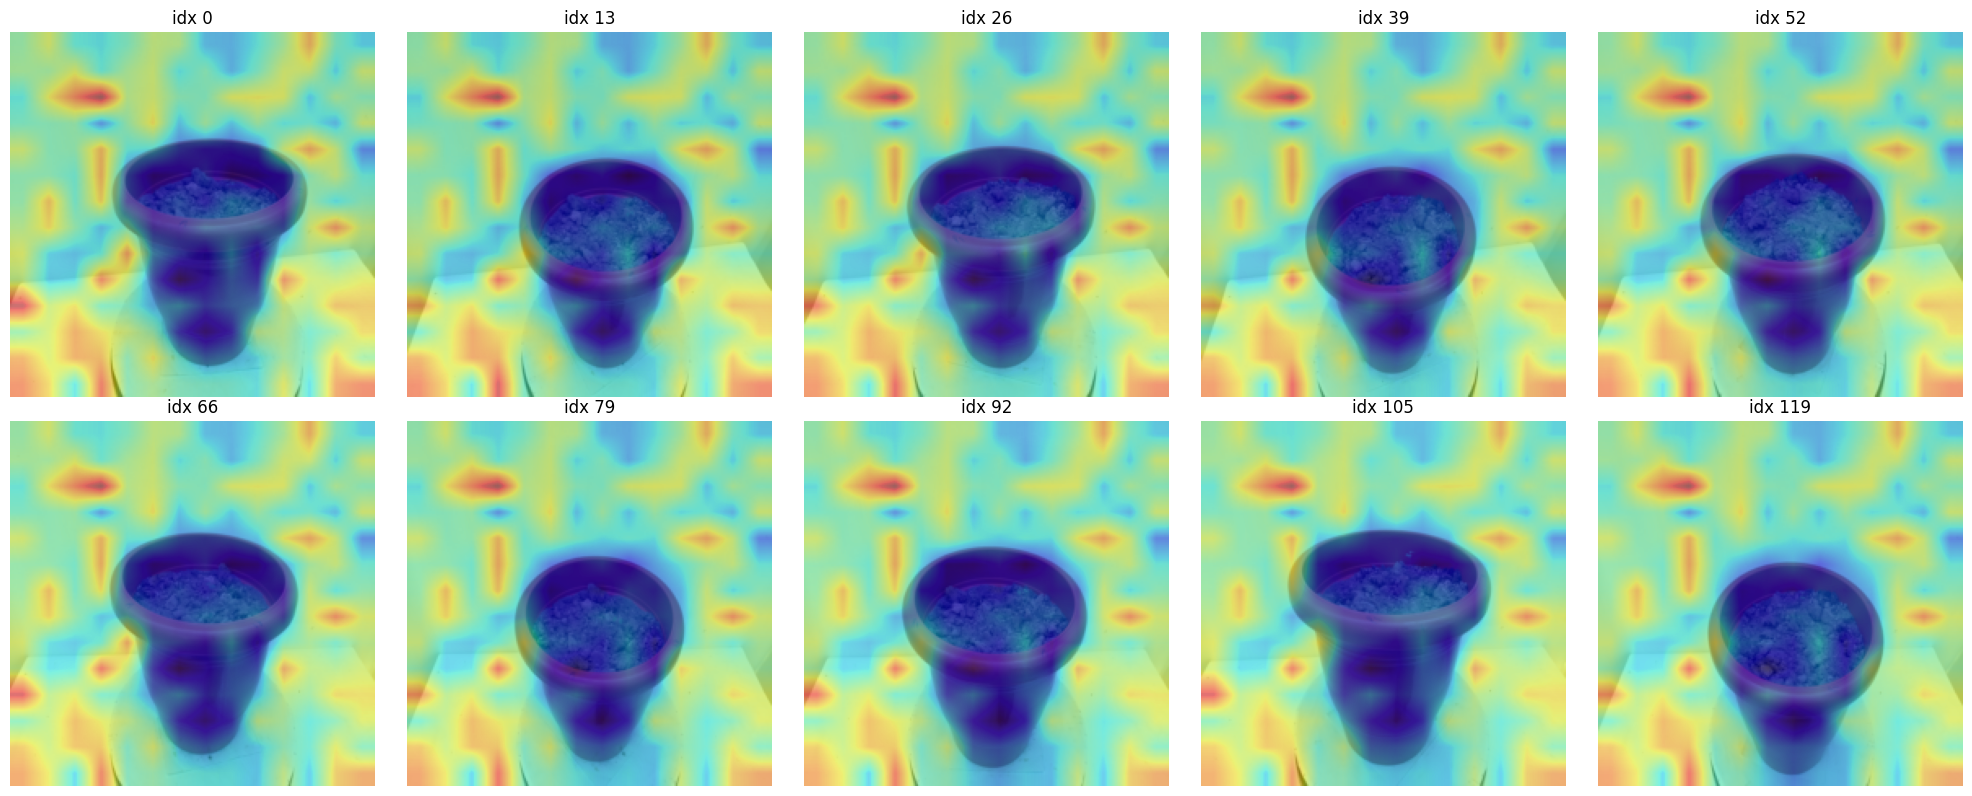

In [30]:
create_attention_grid(model, dataset, device)

In [16]:
print(type(attention_weights))
print(len(attention_weights))
print(type(attention_weights[0]))  # If it's a list, check the type of the first element


NameError: name 'attention_weights' is not defined

In [ ]:
import os

path = '/kaggle/working/'

# List all files (excluding directories)
files = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]
print("Files in directory:")
for file in files:
    print(file)


In [ ]:
for file in files:
    file_path = os.path.join(path, file)
    os.remove(file_path)
    print(f"Deleted: {file_path}")

Saved plant-only image to: output.png


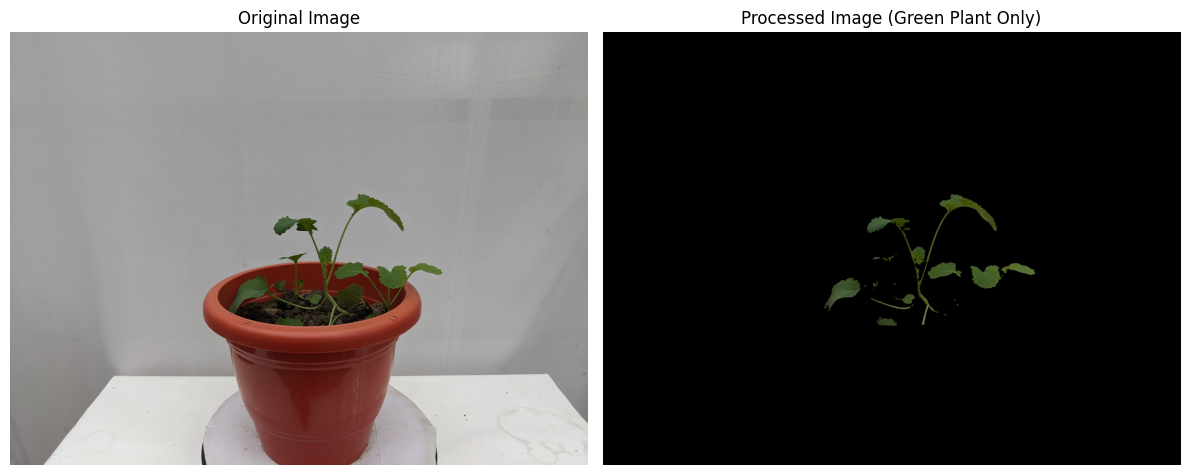

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def isolate_green_plant(image_path, output_path="output.png"):
    # Load image
    image = cv2.imread(image_path)
    if image is None:
        print("Error loading image.")
        return

    # Convert to HSV color space
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Define green color range in HSV
    lower_green = np.array([35, 60, 60])
    upper_green = np.array([85, 255, 255])

    # Create a mask for green color
    mask = cv2.inRange(hsv, lower_green, upper_green)

    # Optional: Clean up mask with morphological operations
    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

    # Apply mask to original image
    result = cv2.bitwise_and(image, image, mask=mask)

    # Make background transparent
    result_rgba = cv2.cvtColor(result, cv2.COLOR_BGR2BGRA)
    result_rgba[:, :, 3] = mask  # Use mask as alpha channel

    # Save output
    cv2.imwrite(output_path, result_rgba)
    print(f"Saved plant-only image to: {output_path}")

# Example usage
isolate_green_plant("/kaggle/input/mustard-dataset/mustard/content/drive/MyDrive/ACM grand challenge/Crops data/For_age_prediction/mustard/p1/d47/L5/mustard_p1_d47_L5_90.png")

# Load original image
original_path = "/kaggle/input/mustard-dataset/mustard/content/drive/MyDrive/ACM grand challenge/Crops data/For_age_prediction/mustard/p1/d47/L5/mustard_p1_d47_L5_90.png"
original = cv2.imread(original_path)
original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)

# Load processed image
processed = cv2.imread("/kaggle/working/output.png", cv2.IMREAD_UNCHANGED)
if processed.shape[2] == 4:
    # If RGBA, convert to RGB for display
    processed = cv2.cvtColor(processed, cv2.COLOR_BGRA2RGB)
else:
    processed = cv2.cvtColor(processed, cv2.COLOR_BGR2RGB)

# Display both
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(original)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(processed)
plt.title("Processed Image (Green Plant Only)")
plt.axis('off')

plt.tight_layout()
plt.show()

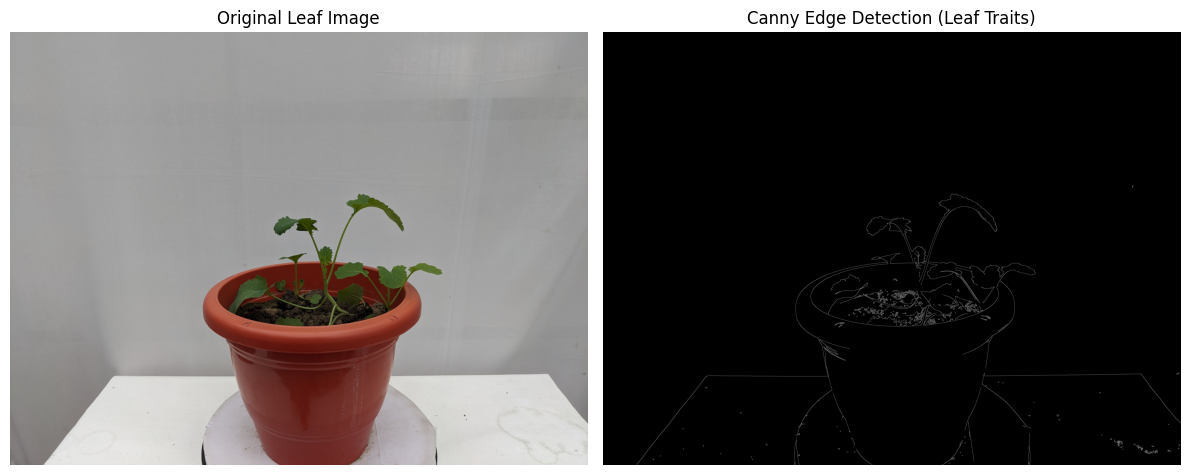

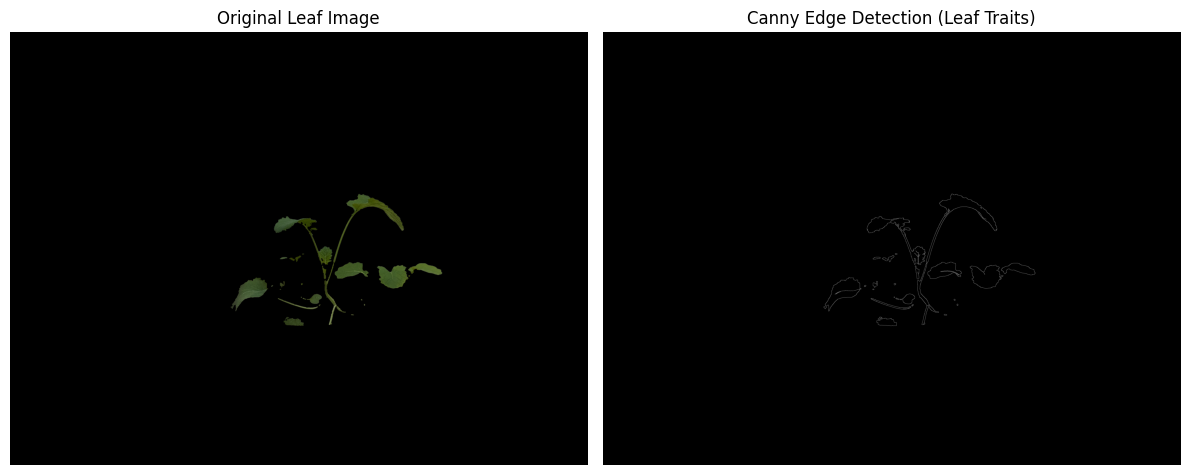

In [15]:
import cv2
import matplotlib.pyplot as plt

def show_leaf_edges(image_path):
    # Load image in color and grayscale
    img_color = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB)  # For display
    img_gray = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian Blur (optional but helps edge detection)
    blurred = cv2.GaussianBlur(img_gray, (5, 5), 0)

    # Apply Canny Edge Detection
    edges = cv2.Canny(blurred, threshold1=50, threshold2=150)

    #--------------------------
    # Apply Gaussian Blur (optional but helps edge detection)
    # blurred = cv2.GaussianBlur(img_gray, (5, 5), 0)

    # Apply Canny Edge Detection
    # edges = cv2.Canny(blurred, threshold1=50, threshold2=150)

    
    # Display both original and edge-detected image
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(img_rgb)
    plt.title("Original Leaf Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(edges, cmap='gray')
    plt.title("Canny Edge Detection (Leaf Traits)")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Example usage
show_leaf_edges("/kaggle/input/mustard-dataset/mustard/content/drive/MyDrive/ACM grand challenge/Crops data/For_age_prediction/mustard/p1/d47/L5/mustard_p1_d47_L5_90.png")
# Example usage
show_leaf_edges("/kaggle/working/output.png")


In [ ]:
import cv2
import numpy as np
import os
from pathlib import Path

def isolate_and_canny(image_path):
    image = cv2.imread(str(image_path))
    if image is None:
        print(f"Failed to load: {image_path}")
        return None

    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower_green = np.array([35, 60, 60])
    upper_green = np.array([85, 255, 255])
    mask = cv2.inRange(hsv, lower_green, upper_green)

    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

    result = cv2.bitwise_and(image, image, mask=mask)

    gray = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150)

    return edges

def process_dataset(input_root, output_root):
    input_root = Path(input_root)
    output_root = Path(output_root)

    for image_path in input_root.rglob("*.png"):  # Change to .jpg if needed
        # Determine the relative path from root
        relative_path = image_path.relative_to(input_root)
        output_path = output_root / relative_path

        # Create output directory if it doesn't exist
        output_path.parent.mkdir(parents=True, exist_ok=True)

        # Process image and save result
        edges = isolate_and_canny(image_path)
        if edges is not None:
            cv2.imwrite(str(output_path), edges)
            print(f"Saved: {output_path}")

# Example usage
input_dir = "/kaggle/input/mustard-dataset/mustard/content/drive/MyDrive/ACM grand challenge/Crops data/For_age_prediction/mustard/p1/d1"
output_dir = "/kaggle/working/canny_output/d1"

process_dataset(input_dir, output_dir)
